<a href="https://colab.research.google.com/github/natsakh/IAD/blob/main/Pr_6/6_2_CNN_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import random
import matplotlib.pyplot as plt

torch.manual_seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device ", device)

device  cuda


In [2]:
# ToTensor() → [0,1]
tf_basic = transforms.ToTensor()

# Завантаження CIFAR-10 (train/test)
root = "./data"
train_set = datasets.CIFAR10(root=root, train=True,  download=True, transform=tf_basic)
test_set  = datasets.CIFAR10(root=root, train=False, download=True, transform=tf_basic)

# Класи (мітки)
classes = train_set.classes
print("Класи CIFAR-10:", classes)

# Перевіримо розміри
x0, y0 = train_set[0]
print("Приклад тензора:", x0.shape, "dtype:", x0.dtype)  # [3,32,32]
print("К-сть train/val:", len(train_set), len(test_set))

100%|██████████| 170M/170M [00:03<00:00, 44.6MB/s]


Класи CIFAR-10: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Приклад тензора: torch.Size([3, 32, 32]) dtype: torch.float32
К-сть train/val: 50000 10000


In [3]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader   = DataLoader(test_set, batch_size=128)

Мітки: ['frog', 'bird', 'ship', 'frog', 'frog', 'truck', 'deer', 'dog', 'deer', 'deer']


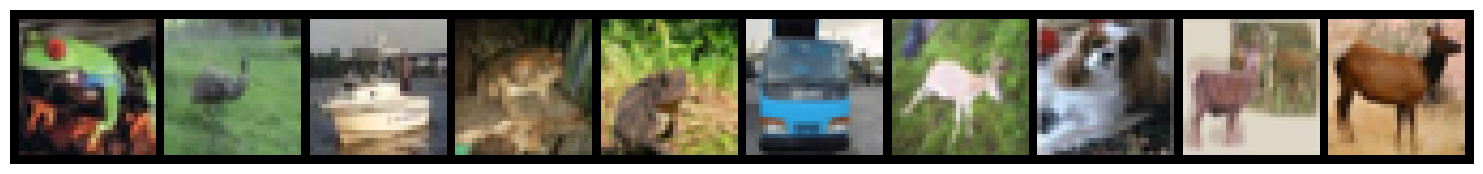

In [4]:
# Відобразимо кілька картинок
def show_batch(dataset, n=10):
    idx = torch.randperm(len(dataset))[:n]
    imgs = [dataset[i][0] for i in idx]
    labels = [dataset[i][1] for i in idx]
    grid = utils.make_grid(imgs, nrow=n, padding=2)
    plt.figure(figsize=(2*n, 2))
    plt.imshow(grid.permute(1, 2, 0))  # C,H,W -> H,W,C
    plt.axis("off")
    print("Мітки:", [classes[l] for l in labels])
    plt.show()

show_batch(train_set, n=10)

In [5]:
# ====== Model ======
class CIFAR_CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # 32x32 -> 32x32
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        # 32x32 -> 32x32 -> 16x16
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2,2)

        # 16x16 -> 16x16 -> 8x8
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2,2)

        self.drop  = nn.Dropout(0.25)

        # після двох пулінгів маємо 128×8×8 = 8192 ознак
        self.fc1 = nn.Linear(128*8*8, 256)
        self.bn4 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))         # [B,32,32,32]
        x = F.relu(self.bn2(self.conv2(x)))         # [B,64,32,32]
        x = self.pool1(x)                           # [B,64,16,16]
        x = F.relu(self.bn3(self.conv3(x)))         # [B,128,16,16]
        x = self.pool2(x)                           # [B,128,8,8]
        x = self.drop(x)
        x = torch.flatten(x, 1)                     # [B,8192]
        x = F.relu(self.bn4(self.fc1(x)))           # [B,256]
        x = self.drop(x)
        logits = self.fc2(x)                        # [B,10]
        return logits

model_basic = CIFAR_CNN().to(device)
print(model_basic)


CIFAR_CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=8192, out_features=256, bias=True)
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [6]:
num_params = sum(p.numel() for p in model_basic.parameters() if p.requires_grad)
print("Trainable params:", num_params)

Trainable params: 2194186


In [7]:
# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_basic.parameters(), lr=1e-3)

In [8]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    train_loss = 0.0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(loader)

    return train_loss

In [9]:
def evaluate_one_epoch(model, loader, criterion, device):
    model.eval()
    valid_loss = 0.0

    with torch.no_grad():
      for x, y in loader:
          x, y = x.to(device), y.to(device)
          out = model(x)
          loss = criterion(out, y)

          valid_loss += loss.item()

    valid_loss /= len(loader)

    return valid_loss

In [10]:
# навчання
n_epochs = 7

for epoch in range(n_epochs):
   train_loss = train_one_epoch(model_basic, train_loader, optimizer, criterion, device)
   val_loss = evaluate_one_epoch(model_basic, test_loader, criterion, device)

   print(f"[{epoch+1:02d}] train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")

[01] train_loss=1.1006 | val_loss=0.8770
[02] train_loss=0.7730 | val_loss=0.7892
[03] train_loss=0.6402 | val_loss=0.7984
[04] train_loss=0.5414 | val_loss=0.6783
[05] train_loss=0.4567 | val_loss=0.6767
[06] train_loss=0.3888 | val_loss=0.6075
[07] train_loss=0.3285 | val_loss=0.7246


In [11]:
torch.save(model_basic.state_dict(), "model_from_scratch.pth")   #save model

In [12]:
@torch.no_grad()
def evaluate_accuracy(model, loader, device):
    """
    Використовується для фінальної оцінки на тестових даних.
    """
    model.eval()
    total_correct = 0
    total_samples = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)                   # [B, num_classes]
        preds = out.argmax(1)            # найбільший логіт → передбачений клас
        total_correct += (preds == y).sum().item()
        total_samples += y.size(0)

    acc = total_correct / total_samples
    return acc

In [13]:
test_acc = evaluate_accuracy(model_basic, test_loader, device)
print(f"Accuracy (CNN from scratch): {test_acc:.4f}")

Accuracy (CNN from scratch): 0.7654


Transfer Learning

In [14]:
#https://docs.pytorch.org/vision/0.8/models.html#classification

# Для Transfer Learning (MobileNet/ResNet/VGG очікують ~224×224 + ImageNet нормалізацію)
# --- ImageNet статистики (для MobileNet/VGG/ResNet) ---
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_tf_imagenet = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

eval_tf_imagenet = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

train_imgnet = datasets.CIFAR10(root=root, train=True,  download=False, transform=train_tf_imagenet)
test_imgnet  = datasets.CIFAR10(root=root, train=False, download=False, transform=eval_tf_imagenet)

train_loader_mobnet = DataLoader(train_imgnet, batch_size=128, shuffle=True)
test_loader_mobnet   = DataLoader(test_imgnet, batch_size=128)

In [15]:
from torchvision import models
mobilenet = models.mobilenet_v2(pretrained=True)

#print(mobilenet)

#  (classifier): Sequential(
#     (0): Dropout(p=0.2, inplace=False)
#     (1): Linear(in_features=1280, out_features=1000, bias=True)
#   )

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 146MB/s]


In [16]:
for i, m in enumerate(mobilenet.features):
    print(i, type(m).__name__)

0 Conv2dNormActivation
1 InvertedResidual
2 InvertedResidual
3 InvertedResidual
4 InvertedResidual
5 InvertedResidual
6 InvertedResidual
7 InvertedResidual
8 InvertedResidual
9 InvertedResidual
10 InvertedResidual
11 InvertedResidual
12 InvertedResidual
13 InvertedResidual
14 InvertedResidual
15 InvertedResidual
16 InvertedResidual
17 InvertedResidual
18 Conv2dNormActivation


In [17]:
# заморозимо фічі
for p in mobilenet.features.parameters():
    p.requires_grad = False

# замінимо класифікатор
in_features = mobilenet.classifier[1].in_features
mobilenet.classifier[1] = nn.Linear(in_features, 10)

In [18]:
total = sum(p.numel() for p in mobilenet.parameters())
trainable = sum(p.numel() for p in mobilenet.parameters() if p.requires_grad)
print(f"total: {total:,} | trainable: {trainable:,}")

total: 2,236,682 | trainable: 12,810


In [19]:
mobilenet = mobilenet.to(device)

In [20]:
# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobilenet.parameters(), lr=1e-3)

In [21]:
# навчання
n_epochs = 7

for epoch in range(n_epochs):
   train_loss = train_one_epoch(mobilenet, train_loader_mobnet, optimizer, criterion, device)
   val_loss = evaluate_one_epoch(mobilenet, test_loader_mobnet, criterion, device)

   print(f"[{epoch+1:02d}] train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")

[01] train_loss=0.9211 | val_loss=0.7073
[02] train_loss=0.7097 | val_loss=0.6589
[03] train_loss=0.6834 | val_loss=0.6435
[04] train_loss=0.6728 | val_loss=0.6350
[05] train_loss=0.6702 | val_loss=0.6390
[06] train_loss=0.6660 | val_loss=0.6199
[07] train_loss=0.6595 | val_loss=0.6577


In [22]:
torch.save(mobilenet.state_dict(), "mobilenet.pth")   #save model

In [23]:
test_acc = evaluate_accuracy(mobilenet, test_loader_mobnet, device)
print(f"Accuracy (mobilenet): {test_acc:.4f}")

Accuracy (mobilenet): 0.7690
